<a href="https://colab.research.google.com/github/Shipra43/AI_plays_snake/blob/master/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps


In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.axis('off')
  plt.imshow(image)

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [ ]:
def draw(image, max_boxes, min_score, boxes, class_names, scores):
  '''
  -- params -- 
  max boxes : maximum no of bounding boxes you want to show in the image
  min_score: threshold value for your desired detection score
  '''
  # get color values from PIL.Image.Color 
  colors = list(ImageColor.colormap.values())

  # get font name from PIL.ImageFont
  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                            25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  detected_boxes = boxes.shape[0] 

  for i in range(min(max_boxes, detected_boxes)):
    if scores[i] >= min_score: # if detection score >= your desired score

      ymin, xmin, ymax, xmax = tuple(boxes[i]) # bbox coordinate values
      
      # decode detected object name with score, example, b'Umbrella' --> Umbrella: 92%
      display_str = "{}: {}%".format(class_names[i].decode("ascii"), 
                                     int(100 * scores[i]))
      
      # set bbox color same to every same class
      color = colors[hash(class_names[i]) % len(colors)]

      # Convert Image to numpy type and RGB
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

      draw_bbox_text_on_image(
          image_pil,
          ymin, xmin,
          ymax, xmax,
          color, font,
          display_str_list=[display_str]
      )
      np.copyto(image, np.array(image_pil))

  return image   

def draw_bbox_text_on_image(image,
                            ymin, xmin,
                            ymax, xmax,
                            color, font, thickness=4,
                            display_str_list=()):
  
    """ Calculates bbox coordinates, text coordinates and draw """

    # creates PIL Draw Object  
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size

    # Formula for bbox coordinate calculation 
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    
    # Draw bbox with coordinates 
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
              (left, top)],
              width=thickness,
              fill=color)

    # get font size from String list
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list] # 11

    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights) # 12
    

    # calculation for showing better class label position with bbox 
    if top > total_display_str_height:
      text_bottom = top
    else:
      text_bottom = top + total_display_str_height
      
    for display_str in display_str_list:
      text_width, text_height = font.getsize(display_str)
      margin = np.ceil(0.05 * text_height)
      
      # draw rectangle with color 
      draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                      (left + text_width, text_bottom)],
                    fill=color)
      
      # put text in drawn colored rectangle 
      draw.text((left + margin, text_bottom - text_height - margin),
                display_str,
                fill="black",
                font=font)

In [ ]:
def run_detector(detector, path, max_boxes, max_score):
  '''
  -- params -- 
  max boxes : maximum no of bounding boxes you want to show in the image
  min_score: threshold value for your desired detection score
  '''

  img = load_img(path)

  # convert jpeg into tf.float32 fromat and add batchsize 1 as dimension 
  converted_img= tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  print('Detecting Image ...')
  output = detector(converted_img) # Returns a dictionary containing bbox values, classnames, scores
  print('Detection Complete\n')

  for key, value in output.items():
    print(f'Key:{key}\nValue:{value}\n\n')
  
  output = {key:value.numpy() for key,value in output.items()}
  print("Found %d objects." % len(output["detection_scores"]))

  image_with_boxes = draw(img.numpy(),
                          max_boxes, max_score,
                          output['detection_boxes'],
                          output['detection_class_entities'], 
                          output['detection_scores'])
  display_image(image_with_boxes)

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<div class="video_container">
  <video autoplay
   width=%d height=%d></video>
  <div style='position: absolute;top: 40px; left: 40px; font-size: 40px; color: green;'>Click to save!</div>
</div>
<script>
var video = document.querySelector('video')
navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""

def take_photo(filename=None, quality=0.8, size=(800,600)):
  """ Take photo from webcam and save it"""
  handle = display(HTML(VIDEO_HTML % (size[0],size[1],quality)), display_id='videoHTML')
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  if filename:
    f = io.BytesIO(binary)
    Image.open(f).save(filename)
  else:
    f = io.BytesIO(binary)
    return np.asarray(Image.open(f))

take_photo('me.jpg')

In [ ]:
faster_rcnn_url = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

# Download sample image using Wget 
!wget -O sample1.jpg 'http://d279m997dpfwgl.cloudfront.net/wp/2016/07/0725_student-loans-debt-getty-1000x683.jpg'
!wget -O sample2.jpg 'https://s36593.pcdn.co/wp-content/uploads/2020/12/089-Chimps-Jamie-Pham.jpg'

# Load model from tensorflow hub
print('loading model...')
detector = hub.load(faster_rcnn_url).signatures['default']
print('model loaded!') 

--2021-11-27 15:13:59--  http://d279m997dpfwgl.cloudfront.net/wp/2016/07/0725_student-loans-debt-getty-1000x683.jpg
Resolving d279m997dpfwgl.cloudfront.net (d279m997dpfwgl.cloudfront.net)... 99.86.227.195, 99.86.227.230, 99.86.227.176, ...
Connecting to d279m997dpfwgl.cloudfront.net (d279m997dpfwgl.cloudfront.net)|99.86.227.195|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172205 (168K) [image/jpeg]
Saving to: ‘sample1.jpg’

sample1.jpg         100%[===================>] 168.17K  --.-KB/s    in 0.005s  

2021-11-27 15:13:59 (30.0 MB/s) - ‘sample1.jpg’ saved [172205/172205]

--2021-11-27 15:14:00--  https://s36593.pcdn.co/wp-content/uploads/2020/12/089-Chimps-Jamie-Pham.jpg
Resolving s36593.pcdn.co (s36593.pcdn.co)... 13.32.182.66, 13.32.182.11, 13.32.182.64, ...
Connecting to s36593.pcdn.co (s36593.pcdn.co)|13.32.182.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188290 (184K) [image/jpeg]
Saving to: ‘sample2.jpg’

sample2.jpg   

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


model loaded!


Detecting Image ...
Detection Complete

Key:detection_class_names
Value:[b'/m/0hnnb' b'/m/0cgh4' b'/m/03bt1vf' b'/m/03bt1vf' b'/m/01g317'
 b'/m/01g317' b'/m/01g317' b'/m/01g317' b'/m/03bt1vf' b'/m/01g317'
 b'/m/01g317' b'/m/09j2d' b'/m/01g317' b'/m/01g317' b'/m/01g317'
 b'/m/01d40f' b'/m/09j2d' b'/m/09j2d' b'/m/05r655' b'/m/04yx4'
 b'/m/03bt1vf' b'/m/01g317' b'/m/01g317' b'/m/09j5n' b'/m/0d4v4'
 b'/m/04yx4' b'/m/0d4v4' b'/m/0d4v4' b'/m/04yx4' b'/m/0d4v4' b'/m/04yx4'
 b'/m/09j2d' b'/m/01g317' b'/m/04yx4' b'/m/07j7r' b'/m/05r655' b'/m/04yx4'
 b'/m/09j5n' b'/m/0d4v4' b'/m/04yx4' b'/m/01g317' b'/m/04yx4' b'/m/0d4v4'
 b'/m/04yx4' b'/m/0d4v4' b'/m/0d4v4' b'/m/04yx4' b'/m/01g317'
 b'/m/03bt1vf' b'/m/0d4v4' b'/m/09j2d' b'/m/09j2d' b'/m/03bt1vf'
 b'/m/09j2d' b'/m/04yx4' b'/m/07j7r' b'/m/01g317' b'/m/0d4v4' b'/m/01g317'
 b'/m/09j2d' b'/m/04yx4' b'/m/04yx4' b'/m/01g317' b'/m/0d4v4' b'/m/04yx4'
 b'/m/09j2d' b'/m/09j2d' b'/m/01bl7v' b'/m/0d4v4' b'/m/0fly7' b'/m/09j2d'
 b'/m/01g317' b'/m/03bt1vf' b'

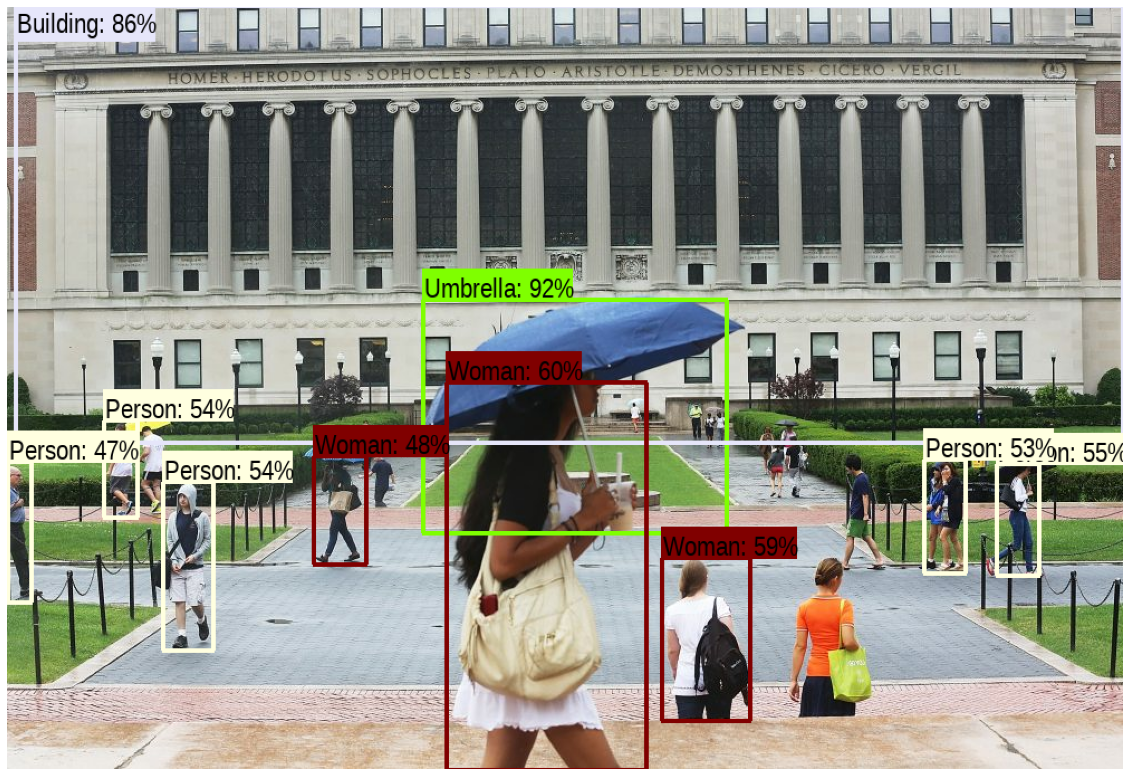

In [ ]:
# Detect Downloaded Image
run_detector(detector, 'sample1.jpg', max_boxes=10, max_score=0.3) # 0.3 means >= 30% accurate 

Detecting Image ...
Detection Complete

Key:detection_class_names
Value:[b'/m/03bt1vf' b'/m/04yx4' b'/m/09j2d' b'/m/04rky' b'/m/09j2d' b'/m/04rky'
 b'/m/04rky' b'/m/09j2d' b'/m/04yx4' b'/m/09j2d' b'/m/07j7r' b'/m/05r655'
 b'/m/09j2d' b'/m/03bt1vf' b'/m/09j2d' b'/m/05r655' b'/m/07j7r'
 b'/m/04rky' b'/m/01g317' b'/m/04yx4' b'/m/03bt1vf' b'/m/01g317'
 b'/m/01g317' b'/m/0jbk' b'/m/09j2d' b'/m/05s2s' b'/m/01g317' b'/m/07j7r'
 b'/m/0jbk' b'/m/01bl7v' b'/m/0jbk' b'/m/01g317' b'/m/03bt1vf' b'/m/07j7r'
 b'/m/01g317' b'/m/07j7r' b'/m/04rky' b'/m/09j2d' b'/m/05s2s' b'/m/01g317'
 b'/m/09j2d' b'/m/03bt1vf' b'/m/07j7r' b'/m/01g317' b'/m/01g317'
 b'/m/01g317' b'/m/01g317' b'/m/0jbk' b'/m/0bwd_0j' b'/m/05r655'
 b'/m/03k3r' b'/m/05s2s' b'/m/09j2d' b'/m/03bt1vf' b'/m/07j7r' b'/m/05s2s'
 b'/m/04yx4' b'/m/01xq0k1' b'/m/03q69' b'/m/09j2d' b'/m/01g317'
 b'/m/05r655' b'/m/05r655' b'/m/09j2d' b'/m/05s2s' b'/m/01g317'
 b'/m/05s2s' b'/m/0fly7' b'/m/07j7r' b'/m/0jbk' b'/m/04yx4' b'/m/01xq0k1'
 b'/m/01g317' b'/m/

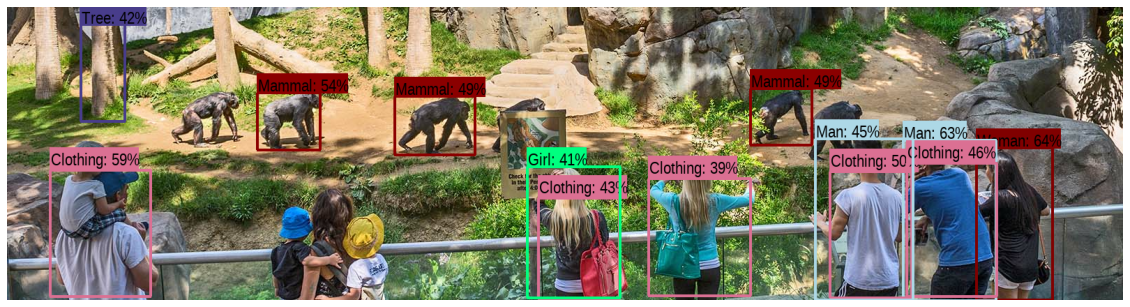

In [ ]:
# Detect Downloaded Image
run_detector(detector, 'sample2.jpg', max_boxes=13, max_score=0.1) # 0.1 = 10% accurate 

Detecting Image ...
Detection Complete

Key:detection_class_names
Value:[b'/m/01mzpv' b'/m/02dgv' b'/m/03jm5' b'/m/0c_jw' b'/m/0c_jw' b'/m/02rdsp'
 b'/m/0fqt361' b'/m/0cgh4' b'/m/01b7fy' b'/m/08dz3q' b'/m/0h8nr_l'
 b'/m/04bcr3' b'/m/01mzpv' b'/m/02jz0l' b'/m/0c_jw' b'/m/01mzpv'
 b'/m/02dgv' b'/m/0h8nm9j' b'/m/0cgh4' b'/m/0c_jw' b'/m/083wq' b'/m/03jm5'
 b'/m/0c_jw' b'/m/0463sg' b'/m/0c_jw' b'/m/04bcr3' b'/m/04bcr3'
 b'/m/01xgg_' b'/m/01mzpv' b'/m/02pkr5' b'/m/03c7gz' b'/m/0138tl'
 b'/m/078n6m' b'/m/01n5jq' b'/m/0h99cwc' b'/m/02pkr5' b'/m/02crq1'
 b'/m/02dgv' b'/m/01b7fy' b'/m/0d4v4' b'/m/0c_jw' b'/m/01mzpv'
 b'/m/0h8nm9j' b'/m/019dx1' b'/m/0c_jw' b'/m/054_l' b'/m/06z37_'
 b'/m/03ssj5' b'/m/09j5n' b'/m/02s195' b'/m/054_l' b'/m/0c_jw'
 b'/m/01mzpv' b'/m/0c_jw' b'/m/0h8nm9j' b'/m/0h9mv' b'/m/03fp41'
 b'/m/0gjbg72' b'/m/01mzpv' b'/m/0cgh4' b'/m/026qbn5' b'/m/02dgv'
 b'/m/04brg2' b'/m/054_l' b'/m/01g317' b'/m/02d9qx' b'/m/0c_jw'
 b'/m/09g1w' b'/m/07k1x' b'/m/02f9f_' b'/m/0h8nr_l' b'/m/06k2mb

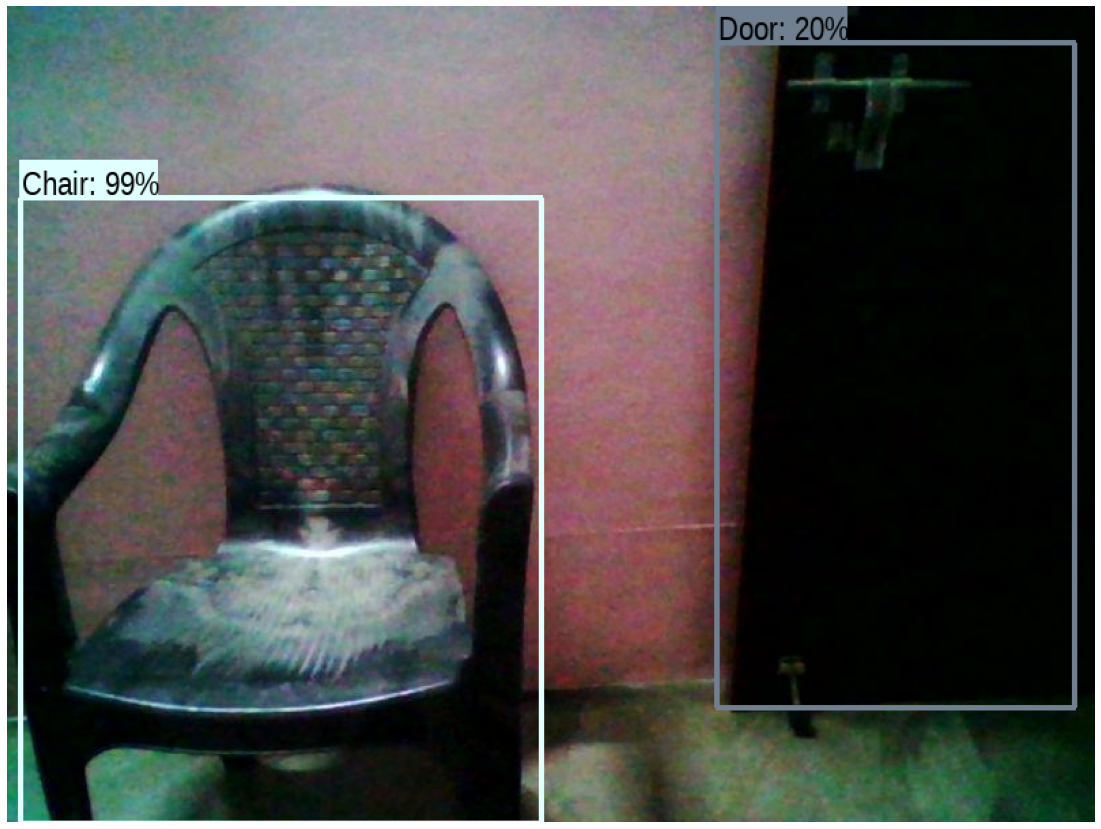

In [ ]:
# Detect Image from webcam
run_detector(detector, 'me.jpg',  max_boxes=8, max_score=0.2) # >=20% accuracy  

In [ ]:
import cv2
import numpy as np
import glob
import random
import matplotlib.pyplot as plt


# Load Yolo
net = cv2.dnn.readNet("yolov3-spp.weights", "yolov3-spp.cfg")

# Name custom object

classes =[]
with open("./coco.names", 'r') as f:

  classes=f.read().splitlines()
img=cv2.imread("image2.jpg")


In [ ]:
classes

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [ ]:

img=cv2.imread("image.jpg")



blob = cv2.dnn.blobFromImage(img,1/255,(320,320),(0,0,0),swapRB=True,crop=False)


In [ ]:
blob.shape
width=320
height=320  

In [ ]:
i=blob[0].reshape(320,320,3)




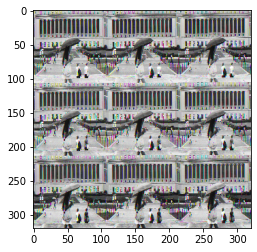

In [ ]:
plt.imshow(i)

In [ ]:
net.setInput(blob)
output_layer_name= net.getUnconnectedOutLayersNames()
layeroutput=net.forward(output_layer_name)
boxes=[]
confidences=[]
class_ids=[]

for output in layeroutput:
  for detection in output:
    score=detection[5:]
    class_id=np.argmax(score)
    confidence=score[class_id]
    if confidence > 0.7:
      center_x = int(detection[0]*width)
      center_y = int(detection[0]*height)
      w = int(detection[0]*width)
      h = int(detection[0]*height)
     

      x = int(center_x-w/2)
      y = int(center_y-h/2)


      boxes.append([x,y,w,h])
      confidences.append(float(confidence))

      class_ids.append(class_id )
      


In [ ]:
len(boxes)


13

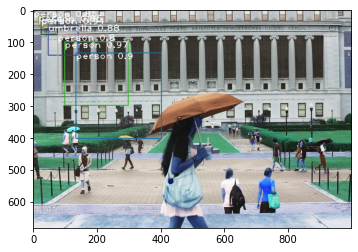

In [ ]:

indexes=cv2.dnn.NMSBoxes(boxes,confidences,0.5,0.4)
font=cv2.FONT_HERSHEY_PLAIN
colors = np.random.uniform(10 , 200 , size=(len(boxes),3))
for i in indexes.flatten():
  x,y,w,h=boxes[i]

  label=str(classes[class_ids[i]])
  confi=str(round(confidences[i],2))
  color=colors[i]

  cv2.rectangle(img,(x,y),(x+w,y+h),color,2)
  cv2.putText(img,label+" "+confi, (x,y+20) ,font,2,(255,255,255),2)
  plt.imshow(img)


In [ ]:
img=cv2.imread("image1.jpg")

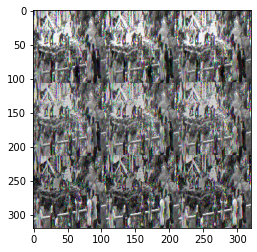

In [ ]:
blob = cv2.dnn.blobFromImage(img,1/255,(320,320),(0,0,0),swapRB=True,crop=False)

blob.shape
width=320
height=320  
i=blob[0].reshape(320,320,3)
plt.imshow(i)

In [ ]:
net.setInput(blob)
output_layer_name= net.getUnconnectedOutLayersNames()
layeroutput=net.forward(output_layer_name)
boxes=[]
confidences=[]
class_ids=[]

for output in layeroutput:
  for detection in output:
    score=detection[5:]
    class_id=np.argmax(score)
    confidence=score[class_id]
    if confidence > 0.7:
      center_x = int(detection[0]*width)
      center_y = int(detection[0]*height)
      w = int(detection[0]*width)
      h = int(detection[0]*height)
     

      x = int(center_x-w/2)
      y = int(center_y-h/2)


      boxes.append([x,y,w,h])
      confidences.append(float(confidence))

      class_ids.append(class_id )
      

In [ ]:
len(boxes)

3

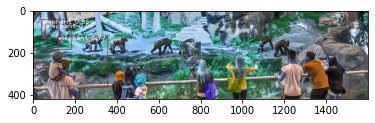

In [ ]:

indexes=cv2.dnn.NMSBoxes(boxes,confidences,0.5,0.4)
font=cv2.FONT_HERSHEY_PLAIN
colors = np.random.uniform(10 , 200 , size=(len(boxes),3))
for i in indexes.flatten():
  x,y,w,h=boxes[i]

  label=str(classes[class_ids[i]])
  confi=str(round(confidences[i],2))
  color=colors[i]

  cv2.rectangle(img,(x,y),(x+w,y+h),color,2)
  cv2.putText(img,label+" "+confi, (x,y+20) ,font,2,(255,255,255),2)
  plt.imshow(img)